### Introduction

In addition to its capabilities to detect and analyze sources with implementations of various array methods, 
Acoular has several tools for synthesizing signals and simulating measurements. 
This can be helpful when designing an experiment and pre-testing measurement setups and algorithms without having to actually set up the hardware.

In this post, we'll be using these tools to simulate the flyby of a multicopter drone as it would be experienced by an arbitrary observer.
Instead of the typical microphone array with dozens of microphones, the output will be restricted to just two channels, which shall represent 
the "ears" of a person.

For applications of the simulation workflow in an array context, see also [here](https://doi.org/10.1051/aacus/2022052) or [here](https://doi.org/10.2514/6.2023-3818).

In the following, we will explore how to:

 - implement an Acoular-compatible class for generating an artificial multicopter signal
 - simulate a source which radiates this signal, has a dipole characteristic and flies along a predefined trajectory
 - export a stereo wav file with a simple auralization of that flyby

First, we import Acoular, NumPy, and Matplotlib's plotting functionality

In [4]:
import acoular as ac
import numpy as np
import matplotlib.pyplot as plt

C:\Users\makky\AppData\Local\Programs\Python\Python313\Lib\site-packages\acoular\__init__.py:10: UserWarning: We detected that Numpy is already loaded and uses OpenBLAS. Because this conflicts with Numba parallel execution, we disable parallel execution for now and processing might be slower. To speed up, either import Numpy after Acoular or set environment variable OPENBLAS_NUM_THREADS=1 before start of the program.
  from .configuration import config


### Generating the drone signal

As Acoular does not feature a specific way to generate drone signals, we define our own signal class for doing that. 
It is derived from the existing [`SignalGenerator`](https://www.acoular.org/api_ref/generated/generated/acoular.signals.SignalGenerator.html#acoular.signals.SignalGenerator) class. 

Signals of multicopter drones are usually very recognizable, often featuring strong tonal components caused by the rotors.
In reality, the radiated noise depends on a lot of factors, which we will not consider in detail here.
For now, it shall be enough to assume the signal to be dependent on the number of rotors (with respective 
rotational speeds) and the number of blades per rotor. 
From that, the blade passing frequencies are calculated as dominant components and nicely mixed with 
some higher harmonics and broadband noise.

The new class shall be called `DroneSignalGenerator` and its interface will allow setting a list of "revolutions per minute" values for the rotors, implicitly setting the numbers of rotors, and the already mentioned number of blades per rotor.

In [5]:
# import traits.api to enforce data types in object parameters
from traits.api import cached_property, Int, List, Property

class DroneSignalGenerator( ac.NoiseGenerator ):
    """
    Class for generating a synthetic multicopter drone signal. 
    This is just a basic example class for demonstration purposes 
    with only few settable and some arbitrary fixed parameters.
    It is not intended to create perfectly realistic signals.
    """

    # List with rotor speeds (for each rotor independently)
    # Default: 1 rotor, 15000 rpm
    rpm_list = List([15000,])

    # Number of blades per rotor
    # Default: 2
    num_blades_per_rotor = Int(2)

    # internal identifier
    digest = Property(depends_on=['rms', 'seed', 'sample_freq', 'num_samples', 'rpm_list', 'num_blades_per_rotor'])

    @cached_property
    def _get_digest(self):
        return digest(self)
        
    def signal( self ):
        """
        function that returns the full signal
        """
        # initialize a random generator for noise generation
        rng = np.random.default_rng(seed = self.seed)
        # use 1/f² broadband noise as basis for the signal
        wn = rng.standard_normal(self.num_samples) # normal distributed values
        wnf = np.fft.rfft(wn) # transform to freq domain
        wnf /= (np.linspace(0.1,1,len(wnf))*5)**2 # spectrum ~ 1/f²
        sig = np.fft.irfft(wnf) # transform to time domain

        # vector with all time instances
        t = np.arange(self.num_samples, dtype=float) / self.sample_freq

        # iterate over all rotors
        for rpm in self.rpm_list:
            f_base = rpm / 60 # rotor speed in Hz

            # randomly set phase of rotor
            phase = rng.uniform() * 2*np.pi
            
            # calculate higher harmonics up to 50 times the rotor speed
            for n in np.arange(50)+1:
                # if we're looking at a blade passing frequency, make it louder
                if n % self.num_blades_per_rotor == 0:
                    amp = 1
                else:
                    amp = 0.2

                # exponentially decrease amplitude for higher freqs with arbitrary factor
                amp *= np.exp(-n/10)
                
                # add harmonic signal component to existing signal
                sig += amp * np.sin(2*np.pi*n * f_base * t + phase) 

        # return signal normalized to given RMS value
        return sig * self.rms / np.std(sig)

Now we use the newly-defined class to create an object with parameters for a specific drone signal. 
We choose to have a quadcopter with four rotors.
As the simulation should feature the drone flying by, it makes sense for two of the rotors running at a higher speed than the other two, so as to tilt a quadcopter to let it fly in one direction. 
Moreover, all rotors are chosen to have slightly different rotational speeds to make it a little more realistic (15010 rpm / 14962 rpm and 13536 rpm / 13007 rpm).

The `sample_freq` and `num_samples` traits that we set here are inherited from the `NoiseGenerator` base class.
We use a standard sampling frequency for audio signals of 44'100 Hz here and generate a signal of a little above 10 seconds.
The strength of the signal can be set via the (also inherited) `rms` trait, but we just use the default value of 1.0 here, so don't have to specifically set it.

In [6]:
# length of signal
t_msm = 10.5 # s
# sampling frequency
f_sample = 44100 # Hz

drone_signal = DroneSignalGenerator(rpm_list = [15010,14962,13536,13007], 
                                    num_blades_per_rotor = 2, 
                                    sample_freq = f_sample, 
                                    num_samples = f_sample*t_msm)

# If you're running the example in an interactive environment, you might want
# to listen to the pure signal by uncommenting the two following lines:
#from IPython.display import Audio
#display(Audio(drone_signal.signal(),rate = f_sample))

The spectrum (PSD) of our signal looks like this:

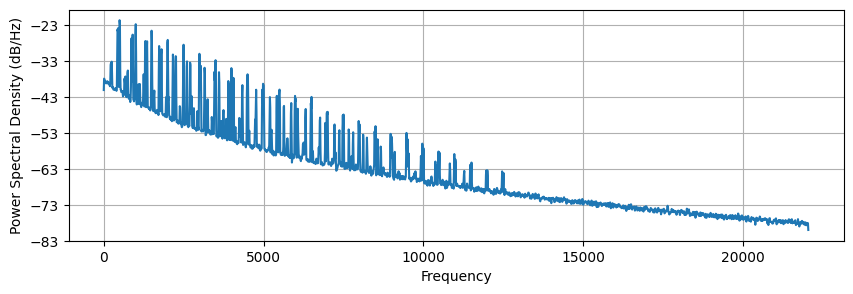

In [7]:
plt.figure(1,(10,3))
plt.psd(drone_signal.signal(), 
        Fs = f_sample,
        NFFT = 4096)
plt.show()

### Microphone positions

In addition to the signal, we need characteristics of the source itself, its movement, the environment, and the way it is observed.
We start with the "observer", i.e. a microphone array with only two microphones where the ears of a standing person might be located. 
The observer's head is looking mostly towards positive $y$, but also slightly to the side from which the drone will come later.

In [8]:
m = ac.MicGeom()
m.pos_total = np.array([[-0.07, 0.07], # x positions, all values in m
                       [-0.03, 0.03], # y
                       [ 1.7 , 1.7]]) # z


### Flight path

Next, the flight path is defined.
A trajectory in Acoular is defined via its "waypoints" with corresponding times.
We can set as many waypoints as we want as a dictionary. 

Let's say that our drone flies about 10 m above ground, 
from left to right, and a little in front of the observer.
The flight speed is 16 m/s in $x$ direction.
The absolute speed will be a little higher, since we slightly and randomly vary the $z$  and $y$ positions from one waypoint to the next.

In [9]:
flight_speed = 16 # m/s

# 11 seconds trajectory, which is a little more than we have signal for
ts = np.arange(12) 

# initialize a random generator for path deviations
rng = np.random.default_rng(seed = 23)

# Set one waypoint each second, 
waypoints = { t : ((t-5.5)*flight_speed,       # vary 
                     6 + rng.uniform(-0.2,0.2), # randomly vary y position up to ±0.2 m around 6 m 
                    10 + rng.uniform(-0.3,0.3)) # randomly vary z position up to ±0.3 m around 10 m height
              for t in ts }

traj = ac.Trajectory(points = waypoints)

Let's plot the trajectory together with the observer positions, as viewed from above.

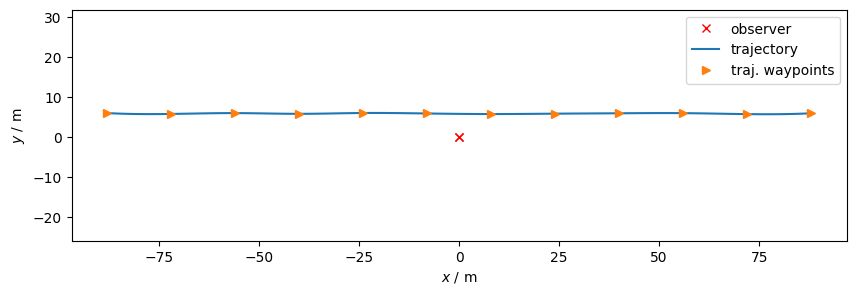

In [10]:
plt.figure(2,(10,3))

# plot observer
plt.plot(m.pos[0,:], m.pos[1,:], 'rx', label = 'observer')

# plot trajectory
times = np.linspace(0,11,100)
xt, yt, zt = traj.location(times)
plt.plot(xt, yt, label = 'trajectory')

# plot the predefined waypoints
xwp, ywp, zwp = zip(*traj.points.values())
plt.plot(xwp, ywp, '>', label = 'traj. waypoints')

plt.xlabel('$x$ / m')
plt.ylabel('$y$ / m')
plt.legend()
plt.axis('equal')
plt.show()

Compared to the length of the flight path, the two observer microphones are positioned rather close to each other, so they appear almost as one position in the plot.

### Drone directivity

Now we define an actual source. Many drones exhibit a strong directivity, so using a [`MovingPointSourceDipole`](https://www.acoular.org/api_ref/generated/generated/acoular.sources.MovingPointSourceDipole.html#acoular.sources.MovingPointSourceDipole) seems a good choice here. 
If we don't explicitly specify otherwise, the dipole lobes will be oriented along the z axis, which is what we want in this case.
For calculating the observed sound pressure, i.e. for taking into account the sound travel path source to the observer, the object needs to know what kind of [environment](https://www.acoular.org/api_ref/generated/acoular.environments.html#module-acoular.environments) it will be existing in.
In our case, we just define a resting fluid with a speed of sound of 343 m/s.

In [11]:
# We'll keep the environment simple for now: just air at standard conditions with speed of sound 343 m/s
e = ac.Environment(c=343.)

# Define point source
p = ac.MovingPointSourceDipole(signal = drone_signal, # the signal of the source
                               trajectory = traj,     # set trajectory
                               conv_amp = True,       # take into account convective amplification
                               mics = m,              # set the "array" with which to measure the sound field
                               start = 0.5,           # observation starts 0.5 seconds after signal starts at drone
                               env = e)               # the environment the source is moving in

With this, we defined our source. But for a little more realism, let's add a "mirror source" to simulate ground reflections. 
The properties of this source are exactly the same as for the original source, except for the $z$ coordinate, which is inversed here.
After the definition of our mirror source, both source are combined into a joint sound field description via a [`SourceMixer`](https://www.acoular.org/api_ref/generated/generated/acoular.sources.SourceMixer.html#acoular.sources.SourceMixer) object.

In [12]:
# Copy the waypoints from the original source into a new trajectory, but with inverted z
waypoints_reflection = { time : (x, y, -z) for time, (x, y, z) in waypoints.items() }
traj_reflection = ac.Trajectory(points = waypoints_reflection)

# Define a mirror source with the mirrored trajectory
p_reflection = ac.MovingPointSourceDipole(signal = drone_signal,        # the same signal as above
                                          trajectory = traj_reflection, # set trajectory of mirror source
                                          conv_amp = True,
                                          mics = m,
                                          start = 0.5,
                                          env = e) 

# Mix the original source and the mirror source
drone_above_ground = ac.SourceMixer( sources = [p, p_reflection] )

### Export a WAV file

Now we export a wav file of our simulation, so that we can listen to it with any audio player software.
Because of the lazy evaluation paradigm, all the code above should run rather quickly, since no serious calculations were done up to now.
This will change here, as the source signal is propagated sample-per-sample to generate the observed sound pressure time signals.
The export may take a few minutes, so don't be alarmed if you don't immediately get the output.

Before letting the data stream be exported as wav file, however, we divert it through a [`TimeCache`](https://www.acoular.org/api_ref/generated/generated/acoular.tprocess.TimeCache.html#acoular.tprocess.TimeCache) object, which already writes the data on the disk (in Acoular-compatible format).
The reason for this is that we do not need to recalculate everything if we happen to need the exact same data at a later point in time.

In [13]:
# Write data stream onto disk for later re-use. This step is not necessary if runtime isn't an issue.
cached_signals = ac.Cache(source = drone_above_ground)

# Prepare wav output.
# If you don't need caching, you can directly put "source = drone_above_ground" here.
output = ac.WriteWAV(file = 'drone_flyby_with_ground_reflection.wav',
                     source = cached_signals, 
                     channels = [0,1]) # export both channels as stereo

# Start the actual export
output.save()

[('void_cache.h5', 1)]


That's it, we did a simple drone auralization using the tools available in Acoular.
If you listen to the output file with properly connected stereo headphones, you should hear something that resembles a quadcopter moving from left to right.

### Spectrogram 

Finally, let's visualize the transient signal of one channel in a spectrogram. 
We use Acoular's [`return_result`](https://www.acoular.org/api_ref/generated/generated/generated/acoular.tools.helpers.return_result.html#acoular.tools.helpers.return_result) function on the output object to get the whole signal track at once instead of from a block-wise yielding generator.

C:\Users\makky\AppData\Local\Programs\Python\Python313\Lib\site-packages\acoular\tools\helpers.py:151: Warning: result method not implemented yet! Data from source will be passed without transformation.
  resulter = (_.copy() for _ in source.result(num))


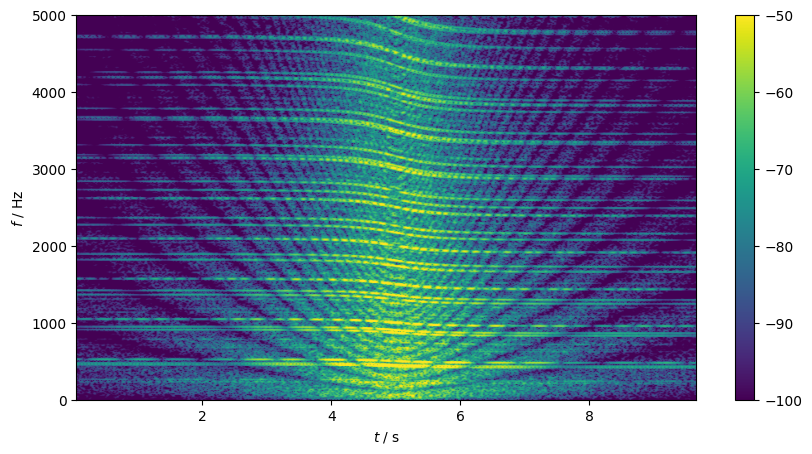

In [14]:
plt.figure(3,(10,5))
plt.specgram(ac.tools.return_result(output)[:,0], 
             Fs = f_sample,
             noverlap = 4096-256,
             NFFT = 4096,
             vmin=-100,
             vmax=-50)
plt.ylim(0,5000)
plt.colorbar()
plt.xlabel('$t$ / s')
plt.ylabel('$f$ / Hz')
plt.show()

Although this simulation is comparativly simple and far from realistic, the spectrogram already exhibits many of the features observed in actual measurement data of drone flybys: the frequency shift due to the Doppler effect, higher levels when the drone is close to the observer, and interference patterns due to ground reflections.

In [ ]:
#hide
plt.figure(4,(7,5))
plt.specgram(ac.tools.return_result(output)[:,0], 
             Fs = f_sample,
             noverlap = 4096-256,
             NFFT = 4096,
             vmin=-100,
             vmax=-50)
plt.ylim(0,5000)
plt.colorbar()
plt.xlabel('$t$ / s')
plt.ylabel('$f$ / Hz')
plt.savefig("thumb_drone_spectrogram.png", transparent=True, dpi=50)